# **Zaber Stage Scan Script**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import types
import scipy.constants
import scipy.io
import time
import datetime
import sys
sys.path.append('../Modules')
import VNA_control as vc
from motion_stages import Zaber_2axis_LST1500D as motion_stage

sleepy_time = 2

C     = scipy.constants.c
EPS_0 = scipy.constants.epsilon_0 #C^2/(N*m^2)
MU_0  = scipy.constants.mu_0    #m kg s^-2 A^-2
mm    = 1E-3
cm    = 1E-2
GHz   = 1.0E9

### Scan parameters

In [2]:
scan = types.SimpleNamespace()

scan.z_offset = 760 # distance from stage to target, mm. CHECK THIS

xrange = 1500 # x length of stage, mm
yrange = 1500 # y length of stage, mm

fstart = 18E9    # start frequency
fstop = 26E9    # end frequency
NumFreqs = 401  # number of frequency points
scan.f = np.linspace(fstart, fstop, NumFreqs)
lam_min = C/fstop
dstep = lam_min/2 * 1000 # mm

scan.IFBW = 1000
scan.calfile = 'green_cables_22-10-27'
scan.power = 0
savename = 'resolution_target'
scan.sParMeas = 'S12'
speedmms = 25

scan.notes = []
scan.notes.append('13 metal spheres in triangular patter, with varying spacing.')

print('IFBW = {} \nCalibration File = {} \nPower = {} dBm \nMeasuring {}'.format(scan.IFBW, scan.calfile, scan.power, scan.sParMeas))

IFBW = 1000 
Calibration File = green_cables_22-10-27 
Power = 0 dBm 
Measuring S12


### Initialize instruments

In [3]:
## Stage
stage = motion_stage()
stage.home_axes()

## VNA
# vna = vc.instrument_open('TCPIP0::169.254.187.153::5025::SOCKET')
vna = vc.instrument_open('TCPIP0::10.236.73.132::5025::SOCKET')
_ = vc.VNA_initiate(vna, NumFreqs, fstart*1E-9, fstop*1E-9, scan.IFBW, scan.power, calfile=scan.calfile)

Agilent Technologies,N5224A,MY51441410,A.09.80.20
Initiating VNA...

Done



### Test calibration file

In [4]:
# test_s11 = vc.VNA_read(vna, 'S11')
# test_s12 = vc.VNA_read(vna, 'S12')
# test_s21 = vc.VNA_read(vna, 'S21')
# test_s22 = vc.VNA_read(vna, 'S22')

# f = np.linspace(18E9, 26E9, NumFreqs)

# plt.figure()
# plt.plot(f, 20*np.log10(np.abs(test_s11)), label='S11')
# plt.plot(f, 20*np.log10(np.abs(test_s12)), label='S12')
# plt.plot(f, 20*np.log10(np.abs(test_s21)), label='S21')
# plt.plot(f, 20*np.log10(np.abs(test_s22)), label='S22')
# plt.legend(frameon=False)
# plt.show()

### Setup scan

Cross-range resolution = $\frac{\lambda z_0}{2D}$ (or $\lambda/4$, whichever is higher)  
Range resolution = $\frac{c}{2B}$

In [6]:
# stage.move_x_absolute(650)
# stage.move_y_absolute(900)

In [7]:
x_center = 750
y_center = 900
Lx_scan = 800
Ly_scan = 800

xmin = x_center-Lx_scan/2
xmax = x_center+Lx_scan/2
ymin = y_center-Ly_scan/2
ymax = y_center+Ly_scan/2

scan.X, scan.Y = np.meshgrid(np.arange(xmin, xmax, dstep), np.arange(ymin, ymax, dstep), indexing='xy')
scan.measurements = np.zeros((scan.X.shape[0], scan.X.shape[1], NumFreqs), dtype=np.complex128)
stops = scan.X.shape[0] * scan.X.shape[1]

### Check scan corners

In [8]:
scan_corners = np.array([[np.amin(scan.X), np.amin(scan.Y)],
                         [np.amin(scan.X), np.amax(scan.Y)],
                         [np.amax(scan.X), np.amax(scan.Y)],
                         [np.amax(scan.X), np.amin(scan.Y)]])

for i in range(scan_corners.shape[0]):
    stage.move_x_absolute(scan_corners[i,0])
    stage.move_y_absolute(scan_corners[i,1])
    time.sleep(sleepy_time)

### Start scan

Est. time remaining: 21.711098250349362 hours
Est. time remaining: 21.825128181907864 hours
Est. time remaining: 21.749247056179577 hours
Est. time remaining: 21.64297681550185 hours
Est. time remaining: 21.527894210749203 hours
Est. time remaining: 21.514869620800017 hours
Est. time remaining: 21.560982652902602 hours
Est. time remaining: 21.764297749466365 hours
Est. time remaining: 21.679786365164652 hours
Est. time remaining: 21.61148710489273 hours
Est. time remaining: 21.72653007540438 hours
Est. time remaining: 21.410426998668246 hours
Est. time remaining: 21.384949944814046 hours
Est. time remaining: 19.003698872261577 hours
Est. time remaining: 21.53196561217308 hours
Est. time remaining: 21.469625796675682 hours
Est. time remaining: 21.45189162552357 hours
Est. time remaining: 21.448294860654407 hours
Est. time remaining: 21.398835028211277 hours
Est. time remaining: 20.735111600028144 hours
Est. time remaining: 21.46601803375615 hours
Est. time remaining: 21.34038969874382 h

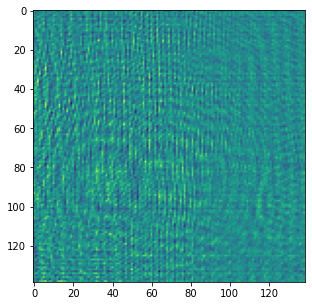

In [5]:
stage.move_x_absolute(scan.X[0,0])
stage.move_y_absolute(scan.Y[0,0])

t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(scan.Y.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(scan.X.shape[1])
    else:
        xindex = np.flip(np.arange(scan.X.shape[1]))
        
    for xn in xindex:
        x = scan.X[yn, xn]
        y = scan.Y[yn, xn]
        stage.move_x_absolute(x)
        stage.move_y_absolute(y)
        time.sleep(sleepy_time)
        
        scan.measurements[yn,xn,:] = vc.VNA_read(vna, scan.sParMeas)
        
        stopscomp += 1
    
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()

plt.figure(figsize=(5,5))
plt.imshow(np.real(scan.measurements[:,:,0]))
plt.show()

### Save data

In [6]:
savepath = './Data/'
scipy.io.savemat('{}{}_{}.mat'.format(savepath, savename, datetime.datetime.now().strftime('%Y-%m-%d')),
                                      scan.__dict__)

### Clean up communications

In [ ]:
vna.close()